# Terrorism Data

The structure of your project must include four components: exploratory data analysis, Bayesian inference to examine the the difference in incidences across the globe, a model to impute the missing values, and a brief description of your methods. 


### Part One: EDA

You should gain an understanding of the attacks (focus on `attacktype1`), their distribution across the world, and their frequency.

You will discover different things than your classmates on this portion. Your presentation should include compelling visualizations describing terror incidents around the world.

You are **required** to produce at least one visualization that is indexed by time. For example, the number of bombings that occurred by year over time.


### Part Two: Bayesian Inference

Terror attacks are a ripe area of research for Bayesian inference. Given their infrequency, it is (thankfully) difficult for us to assume a high number of samples that approach some normal distribution.

Because of this, we should construct a prior about the amount of terror a given area has seen and update that prior with new information (like a new year of attacks or a contrasting country from within the same region). 

You should compare two populations of your choosing using Bayesian inference. We want to know if the amount of terror one area has seen differs in a significant way than another area (or time period!)

For example, if you are interested in knowing if one country in South America differs in a significant way from another area, you may make your prior  assume that some country is a country in South America with μ average attacks and σ variation across South American countries. You would then update that prior with the information of a single country in South America as well as a separate country in South America. How significantly do the resulting posteriors differ? (An important assumption made here is that the time periods are being held constant, perhaps a single year.)

You should structure your own test of populations rather than using the above example. If you're unable to setup a different test, brainstorm with your squad in the Slack chat.

You must justify the prior you selected and interpret your results (use credible intervals.) Remember you can attempt to use different priors (but don't "prior hack" to affect your output!)


### Part Three: 1993

The year 1993 is missing from our dataset! Given there is a wealth of information across different types of attacks, we will focus analysis on `attacktype1` bombings (category 3, as per the codebook)

For this section, you should determine a methodology that allows you to best fill in the missing values. Perhaps you want to consider hemispheres to be separate models, for example. (That's the only hint you'll receive - and even that hint is not an optimal option.)

Once you've created your methodology and imputed the number of bombings in 1993, you should feel free to apply your methodology to **OTHER** attack categories. (Bonus opportunity: turn your method into a pipeline. Use that pipeline to fill in other missing attack values.)


### Part Four: Methods

Please draft a max two page (or four pages double spaced) report discussing your methodology and findings. Visualizations may be included in an appendix.

Your write-up should have two parts: the Bayesian test you constructed and the values you imputed for 1993 attacks.

In your Bayesian inference section, be sure to defend your prior. Comment on your results of the differing populations.

In your missing value imputation modelling portion, justify the model or tactic you used. Bear in mind simply averaging by hemisphere can, theoretically, be a solution. Err on the side of simple and elegant rather than complex to be complex.


# Part One - EDA

In [120]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pymc3 as pm
import numpy as np

%matplotlib inline
from statsmodels.tsa.stattools import adfuller


In [2]:
df = pd.read_csv('~/desktop/globalterrorism.csv', low_memory=False)

In [3]:
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,0,0,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [4]:
df.shape

(156772, 137)

In [5]:
df.isnull().sum()

eventid                    0
iyear                      0
imonth                     0
iday                       0
approxdate            152016
extended                   0
resolution            153270
country                    0
country_txt                0
region                     0
region_txt                 0
provstate              14520
city                     446
latitude                4519
longitude               4519
specificity                0
vicinity                   0
location              114561
summary                66140
crit1                      0
crit2                      0
crit3                      0
doubtterr                  1
alternative           132536
alternative_txt            0
multiple                   0
success                    0
suicide                    0
attacktype1                0
attacktype1_txt            0
                       ...  
propextent            100420
propextent_txt             0
propvalue             125460
propcomment   

The first thing I should do is extract the date

In [6]:
df.iday.isnull().sum()

0

In [7]:
df.iday.value_counts()

15    5571
1     5540
4     5334
16    5319
10    5294
14    5251
9     5247
13    5246
3     5202
2     5193
12    5171
28    5164
11    5155
7     5150
19    5133
20    5132
27    5109
17    5107
8     5043
22    5037
18    5036
26    5021
25    5021
5     5005
23    4981
6     4956
24    4944
21    4894
29    4700
30    4308
31    2614
0      894
Name: iday, dtype: int64

In [8]:
df.imonth.isnull().sum()

0

In [9]:
df.iyear.isnull().sum()

0

In [10]:
df['imonth_fixed']= [str('0' + str(x)) if len(str(x))==1 else str(x) for x in df['imonth']]

In [11]:
df['imonth_fixed']= ['01' if x=='00' else x for x in df['imonth_fixed']]

In [12]:
df['imonth_fixed']= ['01' if x=='0' else x for x in df['imonth_fixed']]

In [13]:
df['idate_fixed']= [str('0' + str(x)) if len(str(x))==1 else str(x) for x in df['iday']]

In [14]:
df['idate_fixed']= ['01' if x=='00' else x for x in df['idate_fixed']]

In [15]:
df["date_combined"] = df["iyear"].map(str) + "-" + df["imonth_fixed"].map(str) + "-" +df['idate_fixed'].map(str)

In [16]:
df['idate_fixed'].value_counts()

01    6434
15    5571
04    5334
16    5319
10    5294
14    5251
09    5247
13    5246
03    5202
02    5193
12    5171
28    5164
11    5155
07    5150
19    5133
20    5132
27    5109
17    5107
08    5043
22    5037
18    5036
25    5021
26    5021
05    5005
23    4981
06    4956
24    4944
21    4894
29    4700
30    4308
31    2614
Name: idate_fixed, dtype: int64

In [17]:
df['date_combined']= pd.to_datetime(df['date_combined'], format='%Y-%m-%d')

In [18]:
df['date_combined'].dtype

dtype('<M8[ns]')

In [99]:
df = df.set_index('date_combined')

In [20]:
df.to_csv('~/desktop/terrorism.csv')

To get a basic idea of the data set, let's ask some questions

In [21]:
# How has the number of terror attacks increased over time?

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,imonth_fixed,idate_fixed,date_combined
0,197000000001,1970,0,0,NaN,0,NaN,58,Dominican Republic,2,...,NaN,PGIS,0,0,0,0,NaN,01,01,1970-01-01
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,PGIS,0,1,1,1,NaN,01,01,1970-01-01
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,PGIS,-9,-9,1,1,NaN,01,01,1970-01-01
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,PGIS,-9,-9,1,1,NaN,01,01,1970-01-01
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,PGIS,-9,-9,1,1,NaN,01,01,1970-01-01
5,197001010002,1970,1,1,NaN,0,NaN,217,United States,1,...,"Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9,-9,0,-9,NaN,01,01,1970-01-01
6,197001020001,1970,1,2,NaN,0,NaN,218,Uruguay,3,...,NaN,PGIS,0,0,0,0,NaN,01,02,1970-01-02
7,197001020002,1970,1,2,NaN,0,NaN,217,United States,1,...,NaN,Hewitt Project,-9,-9,0,-9,NaN,01,02,1970-01-02
8,197001020003,1970,1,2,NaN,0,NaN,217,United States,1,...,"The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0,0,0,0,NaN,01,02,1970-01-02
9,197001030001,1970,1,3,NaN,0,NaN,217,United States,1,...,"David Newman, Sandra Sutherland, and Jon Stewa...",Hewitt Project,0,0,0,0,NaN,01,03,1970-01-03


## Visualizing the Data - over time

### How has the number of terrorist attacks changed over time?

In [22]:
years = df.iyear.value_counts()

In [23]:
years.dtype

dtype('int64')

In [24]:
years = pd.DataFrame(years)

In [25]:
years = years.reset_index(inplace=False)

In [26]:
years.head()

,index,iyear
0,2014,16840
1,2015,14806
2,2013,11990
3,2012,8498
4,1992,5073


In [27]:
years.columns=['year','attacks']

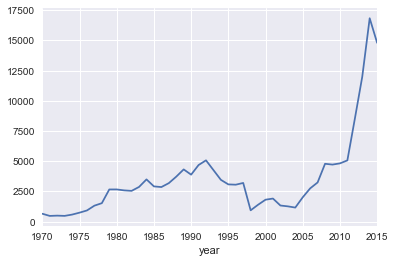

In [28]:
sns.tsplot(years['attacks'], years['year'])
plt.figure(figsize=(20, 15))

# Transform the Data

This is all really useful, but I think looking at individual attacks will not be useful.  What I'd like to do is create some dummie variables to make it easier to sort and transform

In [ ]:
pd.t

### What does the attack type tell us?

In [ ]:
attacktype= df.groupby(by=['iyear'], [''])

In [29]:
types = df.attacktype1.value_counts()

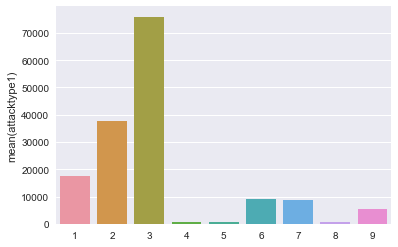

In [30]:
sns.barplot(x=types.index, y=types)


Based on the codebook, the most common type of attacks are:

75963 - Bombings

37554 - Armed Assault

17582 - Assassination

9115 - Kidnapping

8849 - Facility/Infrastructure attack

5490 - Unknown

835 - Hostage Taking

828 - Unarmed Assault

556 - Hijacking 

### What can we learn about locations?

In [31]:
locs = df.region.value_counts()

In [32]:
locs

10    40422
6     37841
3     18628
8     16020
11    13434
5     10360
2     10337
9      4892
1      3268
4       786
7       538
12      246
Name: region, dtype: int64

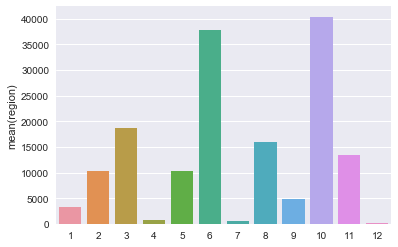

In [33]:
sns.barplot(x=locs.index, y=locs)


### Regions with the most attacks:

Middle East and North Africa 40422    

South Asia 37841

South America 18628

Western Europe 16020

Sub-Saharan Africa 13434

Southeast Asia 10360

Central American & Carribean     10337

Eastern Europe 4892

North America 3268

East Asia 786

Central Asia 538

Australia and Oceania      246


### Attack type by location

# Part 2 - Bayesian Inference 

I want to compare the distribution of the ratio of military terrorist attacks in Pakistan before 2003 to the ratio after 2003.

My prior will be the distribution of terrorist attacks in Afghanistan from the same period.


In [40]:
# first let's take a dataset that's just attacks in Pakistan

df_pakistan = df[df.country == 153]

In [41]:
df_pakistan.shape
#12768 attacks

(12768, 140)

In [36]:
12768/156772.
# wow, 8% of the total terrorism data is from pakistan

0.08144311484193606

In [495]:
df_pre_2003_military.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,imonth_fixed,idate_fixed,date_combined
48290,199110030001,1991,10,3,NaN,0,NaN,153,Pakistan,6,...,NaN,PGIS,-9,-9,0,-9,NaN,10,03,1991-10-03
49074,199111170015,1991,11,17,NaN,1,11/24/91,153,Pakistan,6,...,NaN,PGIS,-9,-9,0,-9,NaN,11,17,1991-11-17
51299,199205090018,1992,5,9,NaN,0,NaN,153,Pakistan,6,...,NaN,PGIS,0,0,0,0,NaN,05,09,1992-05-09
51941,199207030010,1992,7,3,NaN,0,NaN,153,Pakistan,6,...,NaN,PGIS,-9,-9,0,-9,NaN,07,03,1992-07-03
58420,199502140007,1995,2,14,NaN,0,NaN,153,Pakistan,6,...,NaN,PGIS,-9,-9,1,1,NaN,02,14,1995-02-14


In [514]:
### Pre-2003 ratio of terrorist attacks to all attacks
df_pre_2003 = df_pakistan[(df_pakistan.iyear < 2003) & (df_pakistan.iyear > 1990)]
# df_pre_2003_military = df_pre_2003[df_pre_2003.targtype1 == 4]
df_pre_2003_civilian = df_pre_2003[df_pre_2003.targtype1 == 14]
# df_pre_values_mil = df_pre_2003_military.iyear.groupby(df_pre_2003_military['iyear']).value_counts()
df_pre_values_civ = df_pre_2003_civilian.iyear.groupby(df_pre_2003_civilian['iyear']).value_counts()


In [515]:
# combined_pre = pd.DataFrame([df_pre_values_mil,df_pre_values_civ ]).T
# combined_pre.reset_index(level=1,inplace=True)

In [520]:
### Post 2003 ratio of terrorist attacks to all attacks

df_post_2003 = df_pakistan[(df_pakistan.iyear >= 2003)]
# df_post_2003_military = df_post_2003[df_post_2003.targtype1 == 4]
df_post_2003_civilian = df_post_2003[df_post_2003.targtype1 == 14]
# df_post_values_mil = df_post_2003_military.iyear.groupby(df_post_2003_military['iyear']).value_counts()
df_post_values_civ = df_post_2003_civilian.iyear.groupby(df_post_2003_civilian['iyear']).value_counts()


In [521]:
df_post_values_civ

iyear  iyear
2003   2003       3
2004   2004       9
2005   2005      12
2006   2006      38
2007   2007      43
2008   2008     204
2009   2009     217
2010   2010     205
2011   2011     250
2012   2012     340
2013   2013     477
2014   2014     381
2015   2015     206
Name: iyear, dtype: int64

(array([ 5.,  0.,  0.,  0.,  4.,  1.,  0.,  2.,  0.,  1.]),
 array([   3. ,   50.4,   97.8,  145.2,  192.6,  240. ,  287.4,  334.8,
         382.2,  429.6,  477. ]),
 <a list of 10 Patch objects>)

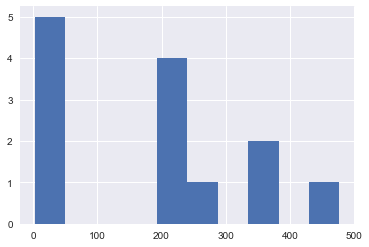

In [550]:
plt.hist(df_post_values_civ)

In [522]:
df_pre_values_civ

iyear  iyear
1991   1991      58
1992   1992      24
1994   1994      56
1995   1995     327
1996   1996      64
1997   1997      58
1998   1998       7
1999   1999       9
2000   2000      17
2001   2001      18
2002   2002       8
Name: iyear, dtype: int64

In [534]:
## Now I need to set my prior distribution:

df_afghanistan = df[(df.country == 4) & (df.targtype1 == 14)]
df_af_values = df_afghanistan.iyear.groupby(df_afghanistan['iyear']).value_counts()
mean_prior_mean = df_af_values.mean()
mean_prior_std = df_af_values.std()

In [535]:
with pm.Model() as model:

    pre_mean = pm.Normal('pre_mean', mean_prior_mean, sd=mean_prior_std)
    post_mean = pm.Normal('post_mean', mean_prior_mean, sd=mean_prior_std)


In [536]:
std_prior_lower = 0.01
std_prior_upper = 100.0

with model:
    
    pre_std = pm.Uniform('pre_std', lower=std_prior_lower, upper=std_prior_upper)
    post_std = pm.Uniform('post_std', lower=std_prior_lower, upper=std_prior_upper)

In [537]:
with model:

    grpt = pm.Normal('group_pre', mu=pre_mean, sd=pre_std, observed=df_pre_values_civ)
    grpaq = pm.Normal('group_post', mu=post_mean, sd=post_std, observed=df_post_values_civ)


In [538]:
with model:

    diff_of_means = pm.Deterministic('difference of means', pre_mean - post_mean)
    diff_of_stds = pm.Deterministic('difference of stds', pre_std - post_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((pre_std**2 + post_std**2) / 2))

In [539]:
with model:
    trace = pm.sample(20000, njobs=4)


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -162.51: 100%|██████████| 200000/200000 [00:22<00:00, 8863.22it/s] 
Finished [100%]: Average ELBO = -162.1
100%|██████████| 20000/20000 [02:04<00:00, 160.03it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x161e1cf10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1620e8710>], dtype=object)

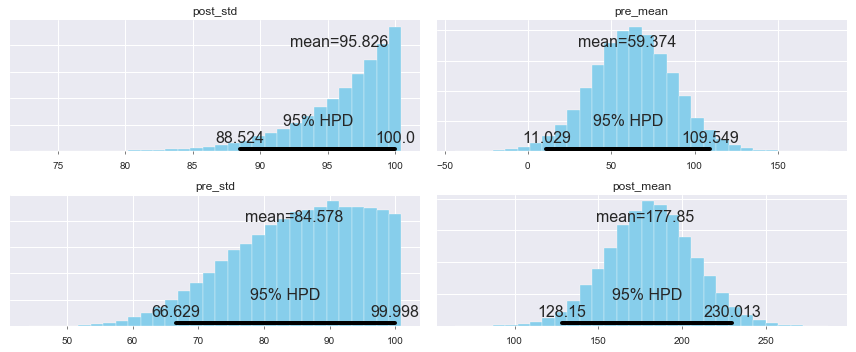

In [542]:
pm.plot_posterior(trace[3000:],
                  varnames=['pre_mean', 'post_mean', 'pre_std', 'post_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15c45e8d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x15d593e90>], dtype=object)

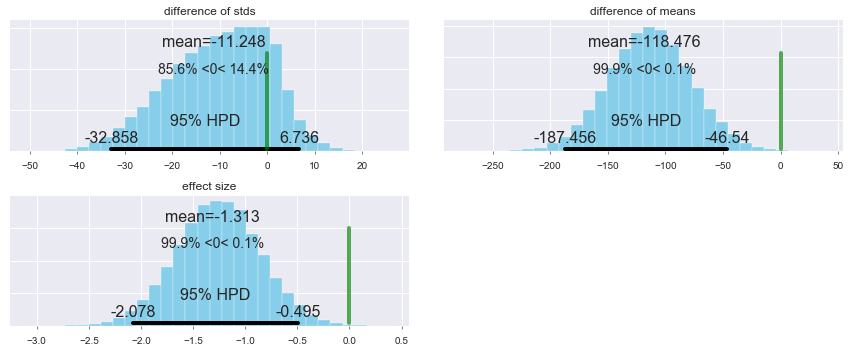

In [541]:
pm.plot_posterior(trace[3000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')


What does this tell us?  The means of the pre -2003 civilian attack frequencies and the post- 2003 civilian attack frequencies are different.  The standard deviation is not within the credible interval. Null hypothesis says they are the same, so we can reject it. based on the actual observed data

credible vs. confidence interval

Standard deviation is not different - 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1620ffc10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x166771ad0>]], dtype=object)

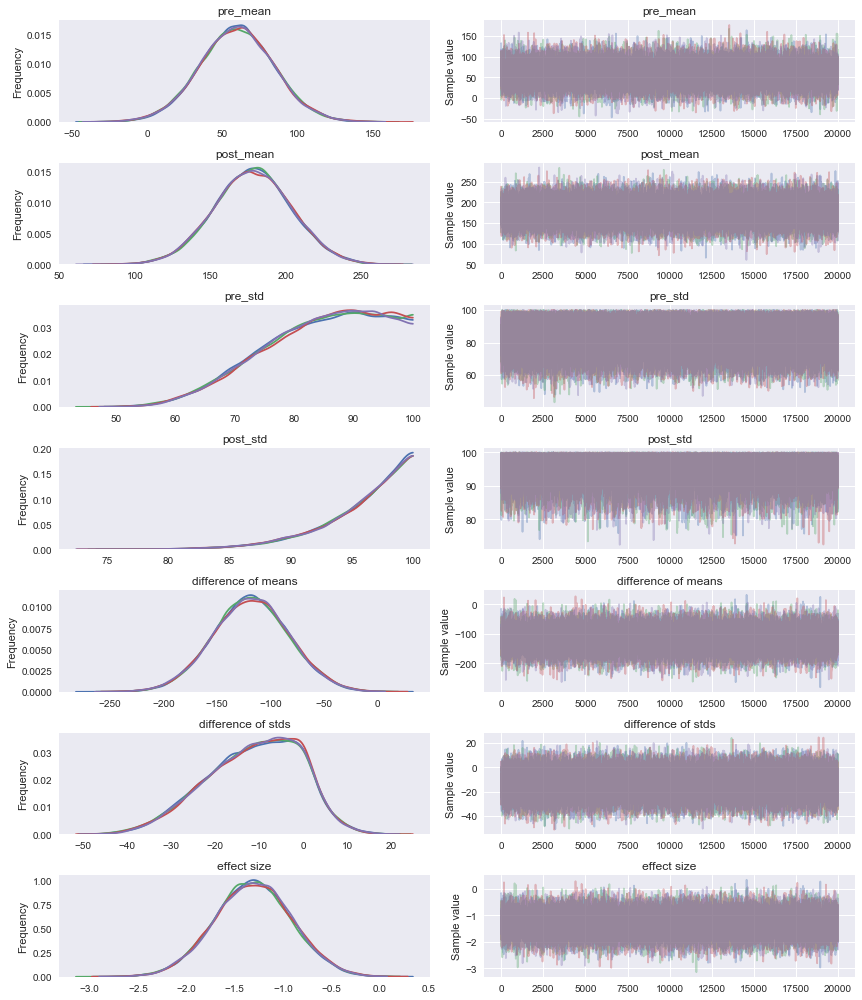

In [545]:
from pymc3 import traceplot

traceplot(trace)

In [543]:
pm.summary(trace[3000:],
           varnames=['difference of means', 'difference of stds', 'effect size'])



difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -118.476         35.928           0.141            [-187.456, -46.540]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -188.903       -142.601       -118.508       -94.515        -47.789


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -11.248          10.576           0.054            [-32.858, 6.736]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -33.238        -18.585        -10.288        -3.078         6.473


effect size:

  Mean             SD               MC Error         95

# PART 3

For this section, you should determine a methodology that allows you to best fill in the missing values. Perhaps you want to consider hemispheres to be separate models, for example. (That's the only hint you'll receive - and even that hint is not an optimal option.)

Once you've created your methodology and imputed the number of bombings in 1993, you should feel free to apply your methodology to **OTHER** attack categories. (Bonus opportunity: turn your method into a pipeline. Use that pipeline to fill in other missing attack values.)


In [421]:
# I need to predict the number of bombings from 1993, so first I need to create a dataframe of just bombings

In [422]:
bombings =df[df['attacktype1']==3]

In [423]:
# bombings.iyear= pd.to_datetime(bombings)

In [424]:
bombings_final = bombings.iyear.value_counts().sort_index()

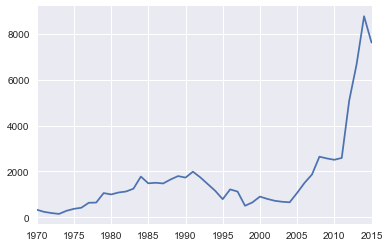

In [425]:
bombings_final.plot()

In [426]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    # rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(window=4,center=False).mean()
    # rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=4,center=False).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 

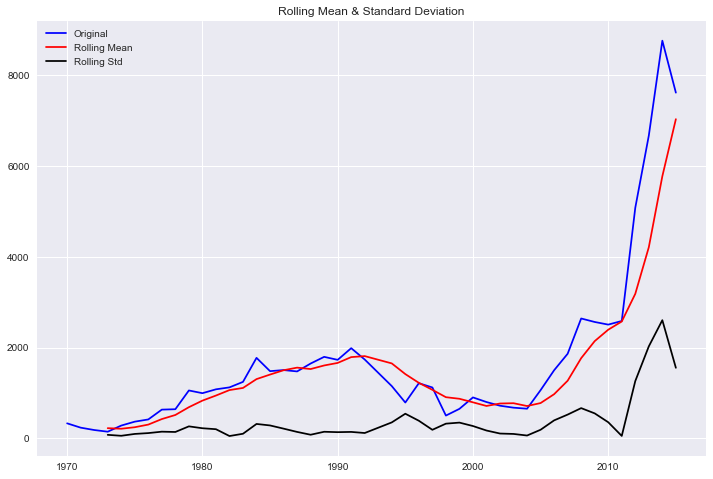

Results of Dickey-Fuller Test:
Test Statistic                 -0.236293
p-value                         0.934055
#Lags Used                      7.000000
Number of Observations Used    37.000000
Critical Value (5%)            -2.943539
Critical Value (1%)            -3.620918
Critical Value (10%)           -2.610400
dtype: float64


In [427]:
test_stationarity(bombings_final)

In [428]:
# That's not very stationary - let's focus on just a few years around the year I'm trying to impute

## Arima 2 .py

In [429]:
bombings_final

1970     333
1971     238
1972     186
1973     149
1974     284
1975     370
1976     419
1977     635
1978     644
1979    1057
1980     997
1981    1082
1982    1125
1983    1246
1984    1775
1985    1482
1986    1506
1987    1476
1988    1650
1989    1797
1990    1731
1991    1988
1992    1738
1994    1153
1995     791
1996    1217
1997    1123
1998     504
1999     652
2000     904
2001     802
2002     721
2003     678
2004     655
2005    1064
2006    1502
2007    1865
2008    2642
2009    2565
2010    2507
2011    2587
2012    5080
2013    6669
2014    8759
2015    7615
Name: iyear, dtype: int64

In [430]:
bombings_final2 =bombings_final[8:23]

In [552]:
bombings_final2

1978-01-01     644.0
1979-01-01    1057.0
1980-01-01     997.0
1981-01-01    1082.0
1982-01-01    1125.0
1983-01-01    1246.0
1984-01-01    1775.0
1985-01-01    1482.0
1986-01-01    1506.0
1987-01-01    1476.0
1988-01-01    1650.0
1989-01-01    1797.0
1990-01-01    1731.0
1991-01-01    1988.0
1992-01-01    1738.0
Name: iyear, dtype: float64

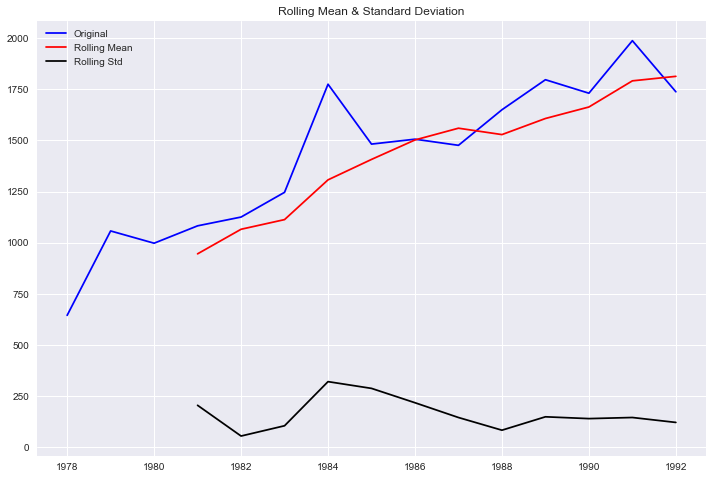

Results of Dickey-Fuller Test:
Test Statistic                -1.262995
p-value                        0.645928
#Lags Used                     5.000000
Number of Observations Used    9.000000
Critical Value (5%)           -3.289881
Critical Value (1%)           -4.473135
Critical Value (10%)          -2.772382
dtype: float64


In [432]:
test_stationarity(bombings_final2)

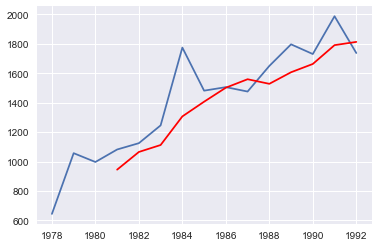

In [433]:
moving_avg = bombings_final2.rolling(window=4,center=False).mean()
plt.plot(bombings_final2)
plt.plot(moving_avg, color='red')

## Let's just use the rolling mean

In [557]:
pd.rolling_mean(bombings_final, window=2)



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2,center=False).mean()
  if __name__ == '__main__':


1970       NaN
1971     285.5
1972     212.0
1973     167.5
1974     216.5
1975     327.0
1976     394.5
1977     527.0
1978     639.5
1979     850.5
1980    1027.0
1981    1039.5
1982    1103.5
1983    1185.5
1984    1510.5
1985    1628.5
1986    1494.0
1987    1491.0
1988    1563.0
1989    1723.5
1990    1764.0
1991    1859.5
1992    1863.0
1994    1445.5
1995     972.0
1996    1004.0
1997    1170.0
1998     813.5
1999     578.0
2000     778.0
2001     853.0
2002     761.5
2003     699.5
2004     666.5
2005     859.5
2006    1283.0
2007    1683.5
2008    2253.5
2009    2603.5
2010    2536.0
2011    2547.0
2012    3833.5
2013    5874.5
2014    7714.0
2015    8187.0
Name: iyear, dtype: float64

In [558]:
# So if I average the rolling mean of 1992 and 1994 I can get an estimate for 1993

In [559]:
(1863.+1445.5) / 2

1654.25

## Below here is my attempt at an ARIMA model, which did not work

In [434]:
ts_moving_avg_diff = bombings_final2 - moving_avg

In [435]:
ts_moving_avg_diff

1978       NaN
1979       NaN
1980       NaN
1981    137.00
1982     59.75
1983    133.50
1984    468.00
1985     75.00
1986      3.75
1987    -83.75
1988    121.50
1989    189.75
1990     67.50
1991    196.50
1992    -75.50
Name: iyear, dtype: float64

In [436]:
ts_moving_avg_diff=ts_moving_avg_diff[3:]

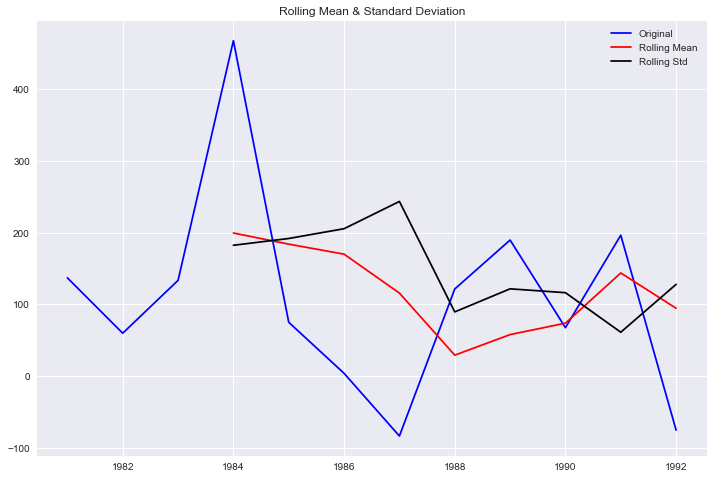

Results of Dickey-Fuller Test:
Test Statistic                -3.319105
p-value                        0.014046
#Lags Used                     4.000000
Number of Observations Used    7.000000
Critical Value (5%)           -3.477583
Critical Value (1%)           -4.938690
Critical Value (10%)          -2.843868
dtype: float64


In [437]:
test_stationarity(ts_moving_avg_diff)

In [438]:
bombings_diff = bombings_final2 - bombings_final2.shift(1)

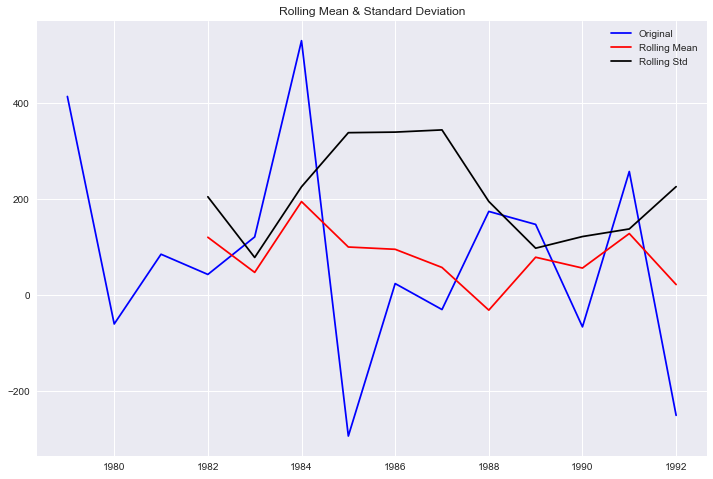

Results of Dickey-Fuller Test:
Test Statistic                -0.000000
p-value                        0.958532
#Lags Used                     6.000000
Number of Observations Used    7.000000
Critical Value (5%)           -3.477583
Critical Value (1%)           -4.938690
Critical Value (10%)          -2.843868
dtype: float64


In [439]:
test_stationarity(bombings_diff.dropna(inplace=False))

In [440]:
# Ok, our p value is less than .05 so this looks stationary enough to use for the model.
# Now that it's stationary I can look at any lagged values

In [441]:
from statsmodels.tsa.stattools import acf, pacf


In [442]:
lag_acf = acf(ts_moving_avg_diff, nlags=5)
lag_pacf = pacf(ts_moving_avg_diff, nlags=5, method='ols')

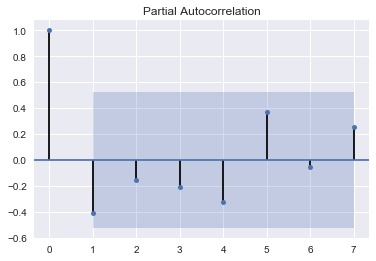

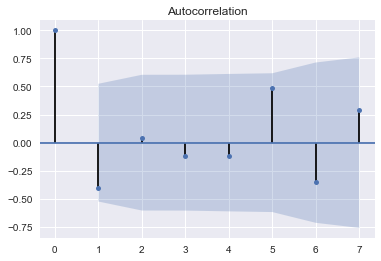

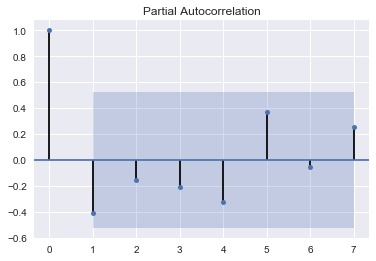

In [443]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(bombings_diff.dropna(inplace=False), lags = 7)
plot_pacf(bombings_diff.dropna(inplace=False), lags = 7)

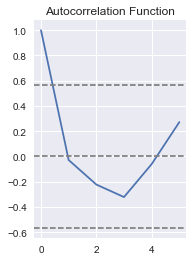

In [444]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

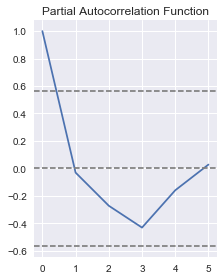

In [445]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

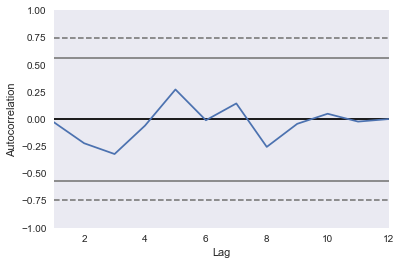

In [446]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(ts_moving_avg_diff)

In [447]:
from statsmodels.tsa.arima_model import ARIMA


In [454]:
bombings_final2.index = pd.to_datetime(bombings_final2.index, format='%Y')

In [455]:
bombings_final2=bombings_final2.astype(float)

In [456]:
bombings_final2

1978-01-01     644.0
1979-01-01    1057.0
1980-01-01     997.0
1981-01-01    1082.0
1982-01-01    1125.0
1983-01-01    1246.0
1984-01-01    1775.0
1985-01-01    1482.0
1986-01-01    1506.0
1987-01-01    1476.0
1988-01-01    1650.0
1989-01-01    1797.0
1990-01-01    1731.0
1991-01-01    1988.0
1992-01-01    1738.0
Name: iyear, dtype: float64

In [474]:
np.isnan(bombings_final2).any()

False

In [475]:
np.isinf(bombings_final2).any()


False

In [482]:
model = ARIMA((bombings_final2), order=(0, 1, 5))
results_AR = model.fit(disp=-1)  
# plt.plot(bombings_diff.dropna(inplace=False))
# plt.plot(results_AR.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-bombings_diff.dropna(inplace=False)))**2)

In [483]:
results_AR.summary()

LinAlgError: Array must not contain infs or NaNs

In [484]:
AR1_pred = results_AR.predict(start='1986-01-01', end = '1994-01-01')

In [485]:
AR1_pred

1986-01-01          NaN
1987-01-01          NaN
1988-01-01          NaN
1989-01-01          NaN
1990-01-01          NaN
1991-01-01          NaN
1992-01-01          NaN
1993-01-01          NaN
1994-01-01    104.20942
Freq: AS-JAN, dtype: float64